In [1]:
%cd drive/MyDrive/collab_sandbox/cerf_text_classification/
!ls

/content/drive/MyDrive/collab_sandbox/cerf_text_classification
blend_models
cerf_classification_cross_distilroberta-base
cerf_classification_distilroberta-base
cerf_classification_machine_learning.ipynb
cerf_classification_roberta-base
cerf_parsing.ipynb
CERF_texts_parsing.zip
cert_classification.ipynb
datasets
learnamericanenglishonline_links.csv
learnamericanenglishonline_links.gsheet
manual_dataset_texts.gsheet
models
runs
wandb


In [2]:
!pip install -q textstat

     |████████████████████████████████| 102kB 6.4MB/s 
     |████████████████████████████████| 1.9MB 12.6MB/s 


In [ ]:
# !pip install -q textstat 'transformers<=3.5.1' 'torch<=1.7.1'

In [3]:
import pandas as pd
import textstat
import json
import spacy
from inspect import signature
# import torch
# import transformers
# from transformers import AutoModel, AutoTokenizer, AutoConfig
# import torch.nn as nn
# from torch.utils.data import Dataset
import numpy as np
import collections
import nltk
import matplotlib.pyplot as plt
import seaborn.apionly as sns
nltk.download('punkt')

nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.7/dist-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
texts_dataset = pd.read_csv("./datasets/level_texts_1959.csv", lineterminator='\n')
word_list = open("./datasets/oxfordlearnersdictionaries.json").read()
word_list = json.loads(word_list)

In [ ]:
ted_stat_words = open("./datasets/ted-counts-5000.txt").read().split("\n")
ted_count_words_total = 3072049 # i counted this before 
ted_stat_words = {item[:item.index('-')].strip() : int(item[item.index('-')+1:].strip()) / ted_count_words_total for item in ted_stat_words}

In [ ]:
ted_stat_words

In [ ]:

# word_list_level = {
#     'A1': [],
#     'A2': [],
#     'B1': [],
#     'B2': [],
#     'C1': []
# }

# for word, level in word_list.items():
#   word_list_level[level.upper()].append(word)

# with open('word_list_level.json', 'w') as outfile:
#     json.dump(word_list_level, outfile)
NER_TYPES = {
    "O": 0,
    'B-a1_be_have_do_in_the_past':1,
    'B-a1_can':2,
    'B-a1_comparative_exept':3,
    'B-a1_comparative_long':4,
    'B-a1_comparative_short':5,
    'B-a1_future_simple':6,
    'B-a1_have_has_got':7,
    'B-a1_past_simple_irreg':8,
    'B-a1_past_simple_reg':9,
    'B-a1_possesive_s_sing':10,
    'B-a1_possessive_s_plurar':11,
    'B-a1_present_continuous_act_rn':12,
    'B-a1_present_simple_3d_pers':13,
    'B-a1_present_simple_reg_act':14,
    'B-a1_special_questions':15,
    'B-a1_superlative_exept':16,
    'B-a1_superlative_long':17,
    'B-a1_superlative_short':18,
    'B-a1_there_is_am_are':19,
    'B-a1_there_was_were':20,
    'B-a1_there_will_be':21,
    'B-a1_to_be_future_will_be':22,
    'B-a1_to_be_past_was_were':23,
    'B-a1_to_be_present_is_am_are':24,
    'B-a1_want_would_like_to':25,
    # inside
    'I-a1_can':26,
    'I-a1_comparative_exept':27,
    'I-a1_comparative_long':28,
    'I-a1_comparative_short':29,
    'I-a1_future_simple':30,
    'I-a1_have_has_got':31,
    'I-a1_past_simple_irreg':32,
    'I-a1_past_simple_reg':33,
    'I-a1_possesive_s_sing':34,
    'I-a1_possessive_s_plurar':35,
    'I-a1_present_continuous_act_rn':36,
    'I-a1_present_simple_3d_pers':37,
    'I-a1_present_simple_reg_act':38,
    'I-a1_special_questions':39,
    'I-a1_superlative_exept':40,
    'I-a1_superlative_long':41,
    'I-a1_superlative_short':42,
    'I-a1_there_is_am_are':43,
    'I-a1_there_was_were':44,
    'I-a1_there_will_be':45,
    'I-a1_to_be_future_will_be':46,
    'I-a1_to_be_past_was_were':47,
    'I-a1_to_be_present_is_am_are':48,
    'I-a1_want_would_like_to':49,
    'I-a1_be_have_do_in_the_past':50,
}
def get_entity_from_sent_lite(sent, label):
    prev_label = label[0][2:]
    sent = [str(token) for token in sent]
    relu = lambda x: x if x > 0 else 0
    accum = []
    ent_len = 0
    start = 0
    for i, tok in enumerate(label):
      tok = tok[2:]
      ent_len += 1
      if tok != label[relu(i-1)][2:]:
        prev_ent = label[relu(i-1)][2:]
        if ent_len > 1 and prev_ent != '':
          accum.append(prev_ent)
        ent_len = 0
        start = i
        
    return accum

class NERDataset():
    def __init__(self, 
                sentences, 
                tags, 
                transformer_tokenizer, 
                transformer_config, 
                TAGS_DICT = None
            ):
        self.sentences = sentences
        self.tags = tags
        self.transformer_tokenizer = transformer_tokenizer
        self.max_len = 128
        self.pad_token_id = transformer_config.pad_token_id
        self.tag_outside_transformed = 0 # let O tag always be zero
        self.TAGS_DICT = TAGS_DICT
    
    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = self.sentences[item]
        tags = self.tags[item]
 
        tags = np.array([self.TAGS_DICT[tok] for tok in tags])
        
        assert len(sentence) == len(tags)

        input_ids = []
        target_tags = []
        tokens = []
        offsets = []
        
        for i, word in enumerate(sentence):
            wordpieces = self.transformer_tokenizer.tokenize(word)
            tokens.extend(wordpieces)
            offsets.extend([1]+[0]*(len(wordpieces)-1))
            target_tags.extend([tags[i]] * len(wordpieces)) 
        
        
        tokens = tokens[:self.max_len - 2] 
        target_tags = target_tags[:self.max_len - 2]
        offsets = offsets[:self.max_len - 2]

        input_ids = self.transformer_tokenizer.encode(tokens)
          
        target_tags = [self.tag_outside_transformed] + target_tags + [self.tag_outside_transformed] 
        masks = [1] * len(input_ids)
        
        token_type_ids = [0] * len(input_ids) 
        offsets = [1] + offsets + [1]

        padding_len = self.max_len - len(input_ids)
        input_ids = input_ids + ([self.pad_token_id] * padding_len)
        masks = masks + ([0] * padding_len)  
        offsets = offsets + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_tags = target_tags + ([self.tag_outside_transformed] * padding_len)  

        return {'input_ids' : torch.tensor(input_ids[:self.max_len], dtype = torch.long),
                'masks' : torch.tensor(masks[:self.max_len], dtype = torch.long),
                'token_type_ids' : torch.tensor(token_type_ids[:self.max_len], dtype = torch.long),
                'target_tags' : torch.tensor(target_tags[:self.max_len], dtype = torch.long),
                'offsets': torch.tensor(offsets[:self.max_len], dtype = torch.long)} 

class NERModel(nn.Module):
    def __init__(self, transformer, device, n_tags, dropout = 0.1):
        super(NERModel, self).__init__()
        transformer_name = transformer.name_or_path
        transformer_config = AutoConfig.from_pretrained(transformer_name)
        self.transformer = transformer
        self.dropout = nn.Dropout(dropout)
        self.tags = nn.Linear(transformer_config.hidden_size, n_tags)
        self.device = device

    def forward(self, 
                input_ids: torch.Tensor, 
                masks: torch.Tensor, 
                token_type_ids: torch.Tensor, 
                target_tags: torch.Tensor, 
                offsets: torch.Tensor 
                ):
        transformer_inputs = {
            'input_ids': input_ids.to(self.device),
            'attention_mask': masks.to(self.device),
            }
        outputs = self.transformer(**transformer_inputs)[0]
        outputs = self.dropout(outputs)
        outputs = self.tags(outputs)
        return outputs

class NERInference:
    def __init__(self, 
                 model_name = 'roberta-base',
                 TAGS = None, 
                 max_len = 128,
                 network = NERModel,
                 ):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.model_name = model_name  
        self.tag_outside = TAGS['O']
        self.TAGS = TAGS
        self.TAGS_NUM = dict([(value, key) for key, value in TAGS.items()])
        self.max_len = max_len
        self.transformer_model = AutoModel.from_pretrained(model_name)
        self.transformer_tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                                                   do_lower_case=True
                                                                   )
        self.transformer_config = AutoConfig.from_pretrained(model_name)  
        self.network = network(self.transformer_model, self.device, len(TAGS), dropout = 0.1)
        self.network.to(self.device)
        self.train_batch_size = 64
        

    def create_dataloader(self, sentences, tags):
      
      data_reader = NERDataset(
          sentences = sentences, 
          tags = tags,
          transformer_tokenizer = self.transformer_tokenizer, 
          transformer_config = self.transformer_config,
          TAGS_DICT = self.TAGS
          )

      data_loader = torch.utils.data.DataLoader(
          data_reader, batch_size = self.train_batch_size,
      )

      return data_loader

    def predict(self, sentences):
      self.network.eval()

      tag_fill = ["O"]
      tags_dummy = [tag_fill * len(sent) for sent in sentences]
      
      dl_test = self.create_dataloader(sentences=sentences, tags = tags_dummy)

      predictions = []
      with torch.no_grad():
        for i, dl in enumerate(dl_test): 
          outputs = self.network(**dl)   

          for i in range(len(outputs)):
              preds = [self.TAGS_NUM[item] for item in outputs[i].argmax(-1).cpu().numpy()]
              # preds = outputs[i]
              preds = [prediction for prediction, offset in zip(preds, dl.get('offsets')[i]) if offset]
              preds = preds[1:-1]
              predictions.append(preds)

      return predictions

# ner_model_tenses =  NERInference(
#   TAGS = NER_TYPES, 
#   model_name = 'roberta-base',
# )
# ner_model_tenses.network.load_state_dict(torch.load(
#     "/content/drive/My Drive/collab_sandbox/NER/ner_tenses_recognition/my_nerda/roberta-base-0.777-0.268-2-22-21.pt",
#      map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ))

<All keys matched successfully>

In [ ]:
example_text = texts_dataset.iloc[710]

text_stat_functions = [
      textstat.flesch_reading_ease,
      textstat.smog_index,
      textstat.flesch_kincaid_grade,
      textstat.coleman_liau_index,
      textstat.automated_readability_index,
      textstat.dale_chall_readability_score,
      textstat.difficult_words,
      textstat.linsear_write_formula,
      textstat.gunning_fog,
      textstat.text_standard,
      textstat.fernandez_huerta,
      textstat.szigriszt_pazos,
      textstat.gutierrez_polini,
      textstat.crawford,
]

tenses_entities = [
  'a1_be_have_do_in_the_past',
  'a1_can',
  'a1_comparative_exept',
  'a1_comparative_long',
  'a1_comparative_short',
  'a1_future_simple',
  'a1_have_has_got',
  'a1_past_simple_irreg',
  'a1_past_simple_reg',
  'a1_possesive_s_sing',
  'a1_possessive_s_plurar',
  'a1_present_continuous_act_rn',
  'a1_present_simple_3d_pers',
  'a1_present_simple_reg_act',
  'a1_special_questions',
  'a1_superlative_exept',
  'a1_superlative_long',
  'a1_superlative_short',
  'a1_there_is_am_are',
  'a1_there_was_were',
  'a1_there_will_be',
  'a1_to_be_future_will_be',
  'a1_to_be_past_was_were',
  'a1_to_be_present_is_am_are',
  'a1_want_would_like_to',
]

# for func in text_stat:
#   if 'float_output' in str(signature(func)):
#     print('he')

In [ ]:
from functools import lru_cache
from concurrent.futures import ProcessPoolExecutor
import nltk
import itertools


def process_example(dataset_item):
  level = dataset_item['level']
  source_text_len = dataset_item['source_text_len']
  text = dataset_item['source_text']
  
  dataset_item = {}
  dataset_item['source_text'] = text
  dataset_item['level'] = level
  dataset_item['source_text_len'] = source_text_len
  
  for stat_func in text_stat_functions:
    feature_name = str(stat_func.__name__)
    result = 0
    if 'float_output' in str(signature(stat_func)):
      result = stat_func(text, float_output=True)
    else:
      result = stat_func(text)

    dataset_item[feature_name] = result
  
  cerf_levels = {'A1': 0, 'A2': 0, 'B1': 0, 'B2': 0, 'C1': 0}

  text_sentences = nltk.sent_tokenize(text)

  # with ProcessPoolExecutor(max_workers=2) as executor:
  #     lemmas = list(executor.map(get_lemmas, text_sentences))
  # lemmas = list(itertools.chain(*lemmas))

  # for item in lemmas:
  #   if word_list.get(item, False):
  #     level = word_list[item].upper()
  #     cerf_levels[level] += 1
  
  level_word_occur = {}
  ted_word_occur = {word:0 for word in ted_stat_words.keys()}
  for item in nlp(text):
    lemma = str(item.lemma_)
    if word_list.get(lemma, False) and level_word_occur.get(lemma, True):
      level = word_list[lemma].upper()
      level_word_occur[lemma] = False
      cerf_levels[level] += 1

    # ted words counts
    if ted_stat_words.get(lemma, False):
      ted_word_occur[lemma] += 1


  
  for key in cerf_levels.keys():
    feature_name = 'word_count_' + key 
    dataset_item[feature_name] = cerf_levels[key]

  for key in ted_stat_words.keys():
    feature_name = 'word_count_' + key 
    dataset_item[feature_name] = ted_stat_words[key] * ted_word_occur[key]
  
  # for entity in tenses_entities:
  #   dataset_item[entity] = 0

  # text_entities_list = []
  # sentences = [[str(i) for i in nlp(str(sent))] for sent in text_sentences]
  # predicts = ner_model_tenses.predict(sentences)
  # for sent, pred in zip(sentences, predicts):
  #   entities = get_entity_from_sent_lite(sent, pred)
  #   text_entities_list.extend(entities)
  
  # text_entities_count = dict(collections.Counter(text_entities_list))
  # for key, value in text_entities_count.items():
  #   dataset_item[key] = value

  return dataset_item
  

In [ ]:
some = process_example(texts_dataset.iloc[100])

In [ ]:
some.keys()

dict_keys(['source_text', 'level', 'source_text_len', 'flesch_reading_ease', 'smog_index', 'flesch_kincaid_grade', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'difficult_words', 'linsear_write_formula', 'gunning_fog', 'text_standard', 'fernandez_huerta', 'szigriszt_pazos', 'gutierrez_polini', 'crawford', 'word_count_A1', 'word_count_A2', 'word_count_B1', 'word_count_B2', 'word_count_C1', 'word_count_go', 'word_count_one', 'word_count_people', 'word_count_like', 'word_count_get', 'word_count_think', 'word_count_would', 'word_count_know', 'word_count_say', 'word_count_make', 'word_count_see', 'word_count_thing', 'word_count_time', 'word_count_year', 'word_count_want', 'word_count_look', 'word_count_take', 'word_count_way', 'word_count_work', 'word_count_come', 'word_count_really', 'word_count_world', 'word_count_well', 'word_count_could', 'word_count_laughter', 'word_count_use', 'word_count_life', 'word_count_need', 'word_count_right', 'word_count

In [ ]:
some.values()

dict_values(['There is fighting between Armenia and Azerbaijan. It is over a border area called Nagorno-Karabakh. Civilians and soldiers died in the clashes. Armenia said Azerbaijan started the conflict by launching missiles. Azerbaijan said it launched missiles to keep the population safe. Tensions started after the Nagorno-Karabakh War in 1994. The current fighting is the worst in many years. A journalist said it was, "a very serious escalation". Turkey is backing Azerbaijan. Russia is backing Armenia. It called for urgent talks. Iran offered to arrange peace talks.', 'A1', 560, 72.63, 8.6, 4.9, 10.97, 8.2, 7.85, 21, 3.5, 5.67, 9.0, 109.5, 103.32, 41.03, 1.3, 23, 9, 1, 7, 3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02168031825013208, 0.0, 0.0, 0.0, 0.0, 0.005730377347496736, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006992075972746529, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006466693727866971, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0029621923348227843, 0.0,

In [ ]:
dataframe_data = []
for i in range(len(texts_dataset)):
  row = texts_dataset.iloc[i]
  row = process_example(row)
  # texts_dataset_stats = texts_dataset_stats.append(row, ignore_index=True)
  if i % 10 == 0:
    print(f"Precessed -> {i/len(texts_dataset)}%")
  dataframe_data.append(row.values())

texts_dataset_stats = pd.DataFrame(columns=list(some.keys()), data=dataframe_data)
# texts_dataset_stats

In [ ]:
# texts_dataset_stats.to_csv("./datasets/texts_dataset_stats_word_counts.csv", index=False)

In [6]:
LABELS_ENCODER =  {
  'A1': 0,
  'A2': 1,
  'B1': 2,
  'B2': 3,
  'C1': 4
}
texts_dataset_stats = pd.read_csv("./datasets/texts_dataset_stats.csv" , lineterminator='\n')
texts_dataset_stats['level_num'] = texts_dataset_stats['level'].apply(lambda x: LABELS_ENCODER[x])
# texts_dataset_stats = texts_dataset_stats.drop(columns=['source_text', 'level'])
# texts_dataset_stats = texts_dataset_stats.drop(columns=tenses_entities)
# texts_dataset_stats

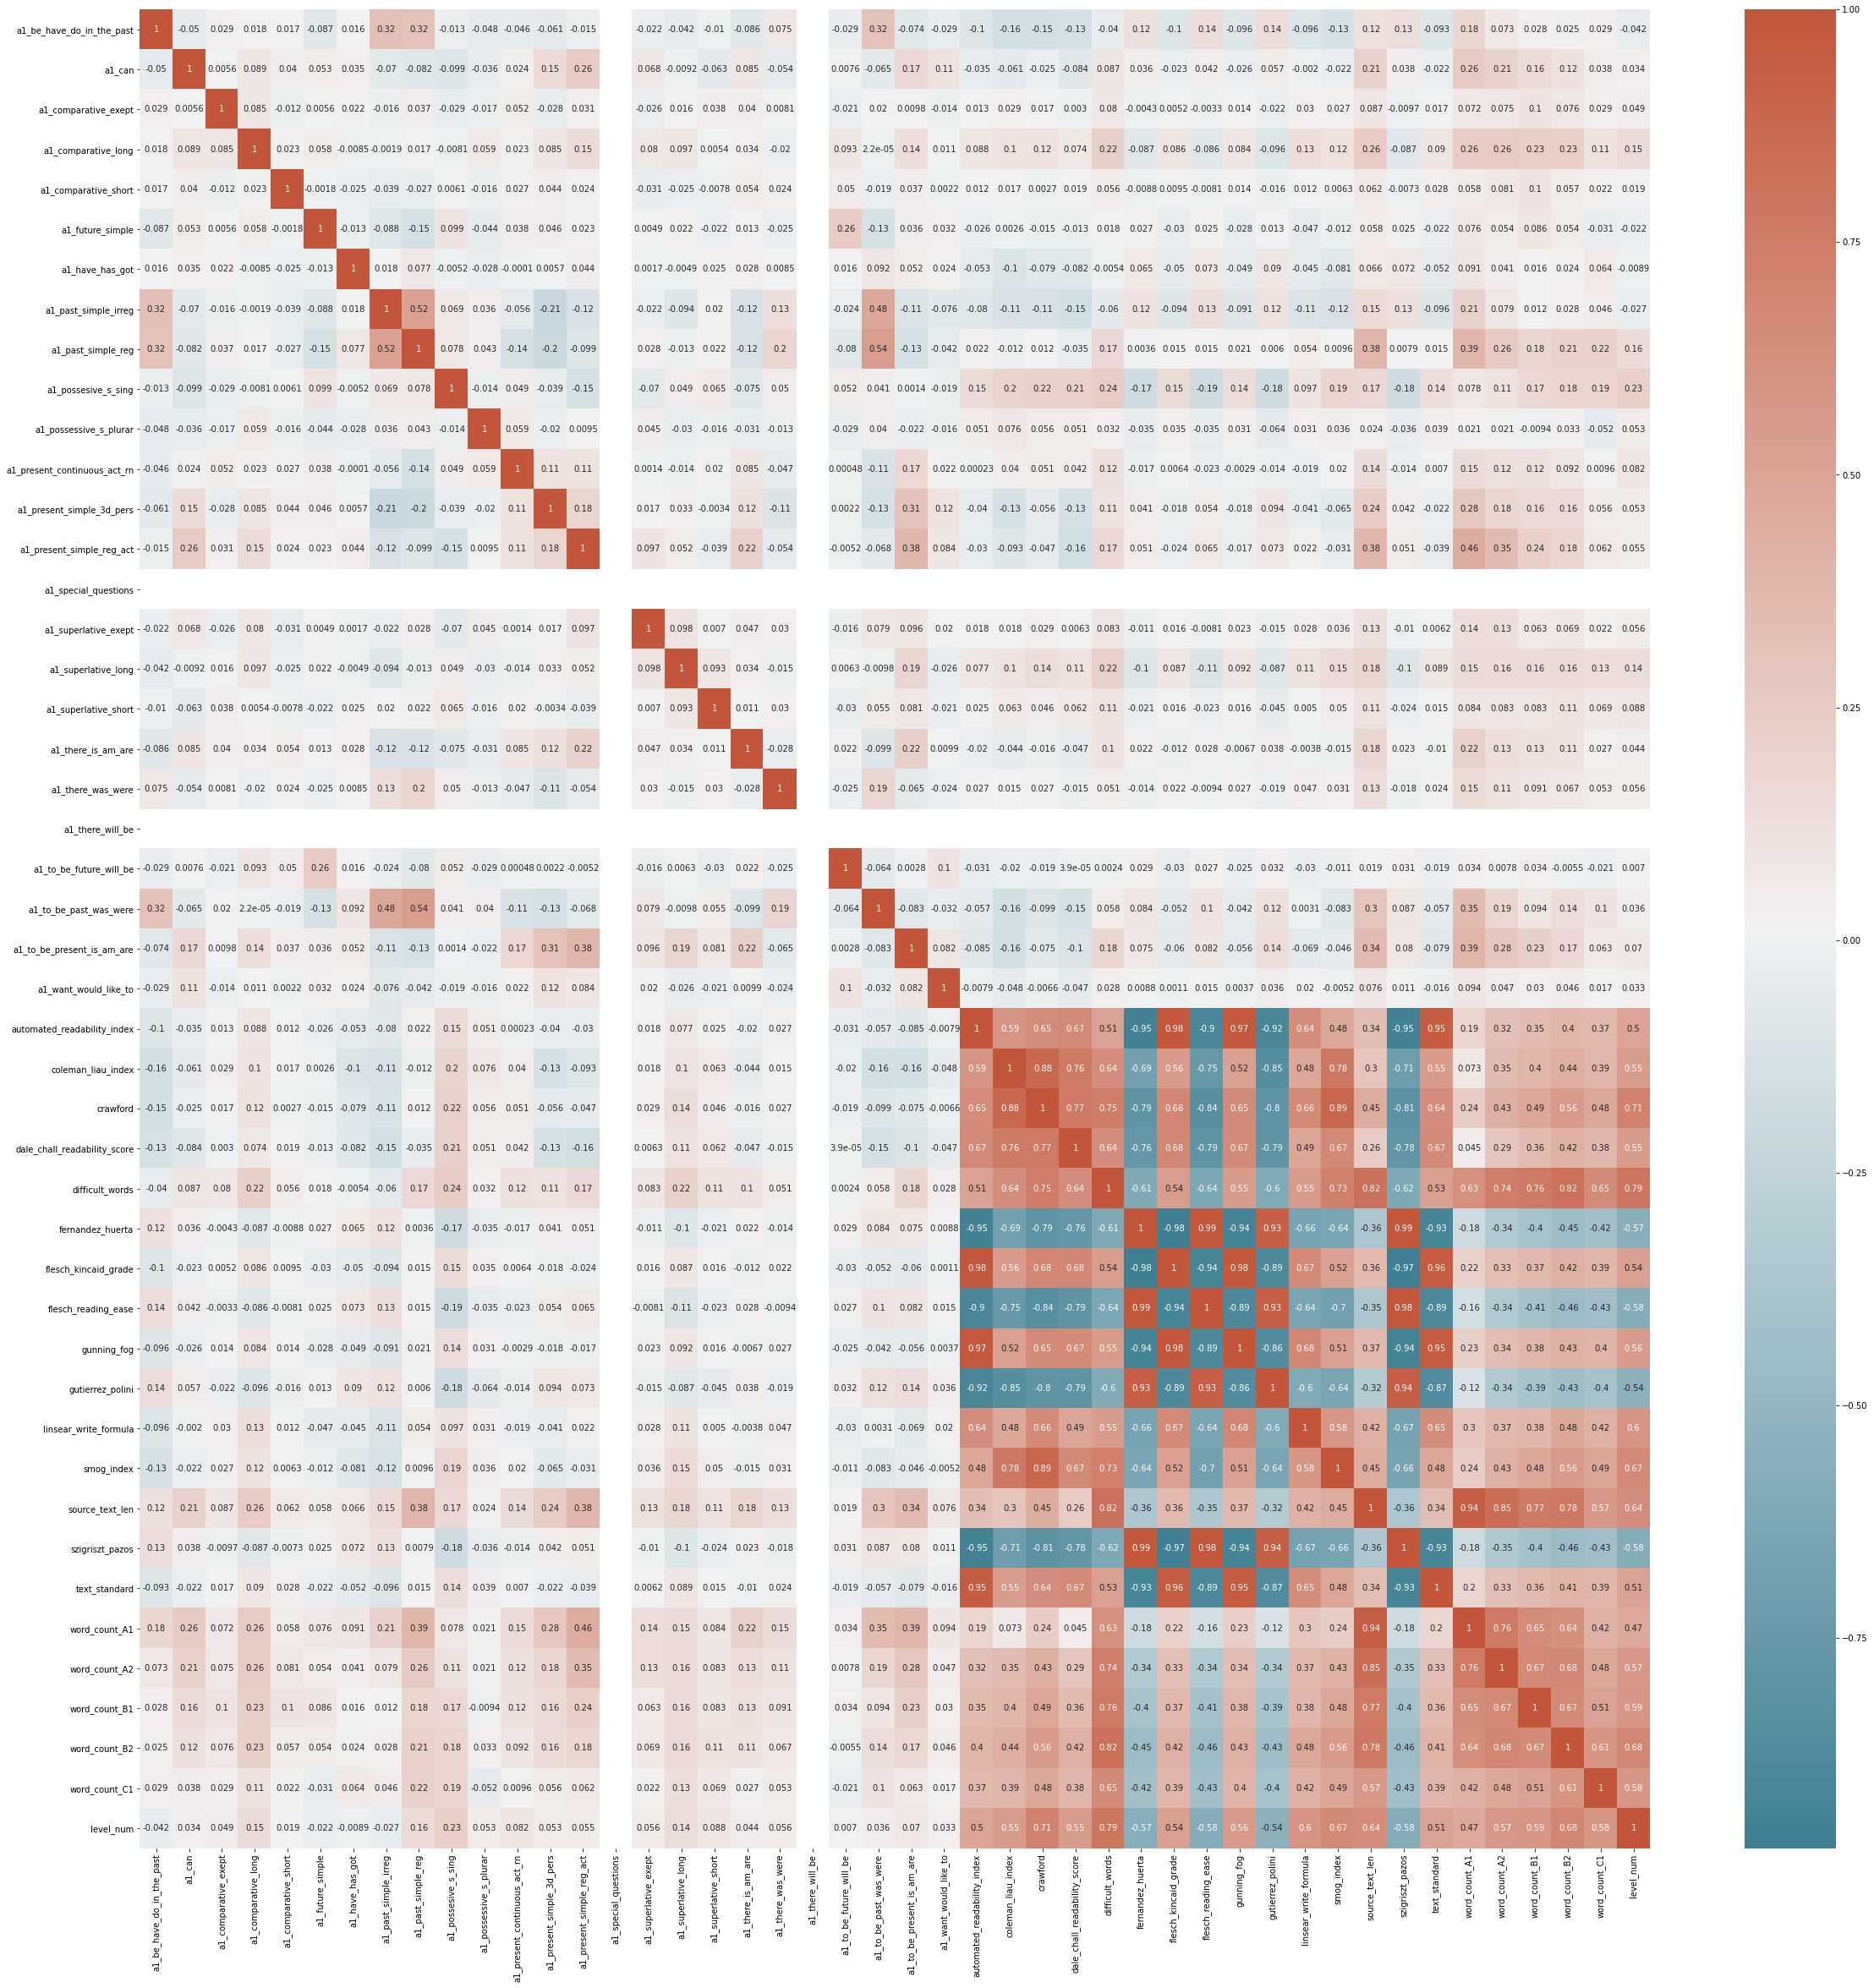

In [7]:
fig, ax = plt.subplots(figsize=(40,40))
corr = texts_dataset_stats.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax)

In [ ]:
mean_scores = {}
for column in texts_dataset_stats.columns:
    mean = texts_dataset_stats.groupby("level_num")[column].mean()
    mean_scores[column] = mean


fig, axs = plt.subplots(len(mean_scores))
fig.set_size_inches((10, 150))
for i, (title, data) in enumerate(mean_scores.items()):
    axs[i].plot(data.index, data.values)
    axs[i].set_title(f"↓ {title} ↓")

In [ ]:
# texts_dataset_stats = texts_dataset_stats.values

In [ ]:
texts_dataset_stats

# Make predictions

In [ ]:
!pip install -q pytorch-tabnet

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
import xgboost

X = texts_dataset_stats.drop(columns=[ 'level_num']).values
y = texts_dataset_stats[[ 'level_num']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1234)
 
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test) # prev best 0.86
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LightGBM Model accuracy score: 0.8639


In [ ]:

clf_boost = xgboost.XGBClassifier(random_state=1234)
# search params
X = texts_dataset_stats.drop(columns=[ 'level_num']).values
y = texts_dataset_stats[[ 'level_num']].values

param_grid_boost = {
  # 'booster': ['gbtree',],
  # 'n_estimators': [500],
  # "learning_rate" : [0.1, ] ,
  # "max_depth" : [3],
  # "min_child_weight" : [ 10, 30, 40, 50, 60],
  # "gamma" : [ 0.5, ],
  # "colsample_bytree" : [ 0.5, ],
  # 'scale_pos_weight': [2, ],
  # 'reg_alpha': [ 0.1, ],
  # 'reg_lambda': [1.0,],
  # 'subsample': [0.9,],
  # "n_jobs": [-1],
}
# создадим объект GridSearchCV
search_boost = GridSearchCV(clf_boost, param_grid_boost, n_jobs=-1, cv=5, scoring='accuracy', )

# запустим поиск
search_boost.fit(X, y)

# выведем наилучшие параметры
print(search_boost.best_params_)
print(search_boost.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{}
0.8119878386137065


## Pretrain

In [ ]:
# X = texts_dataset_stats.drop(columns=[ 'level_num']).values
# y = texts_dataset_stats[[ 'level_num']].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1234)

# unsupervised_model = TabNetPretrainer(
#     optimizer_fn=torch.optim.Adam,
#     optimizer_params=dict(lr=2e-2),
#     mask_type='entmax' # "sparsemax"
# )
# unsupervised_model.fit(
#     X_train=X_train,
#     eval_set=[X_test],
#     pretraining_ratio=0.8,
# )

In [ ]:
# clf = TabNetClassifier(
#     optimizer_fn=torch.optim.Adam,
#     optimizer_params=dict(lr=2e-2),
#     scheduler_params={"step_size":10, # how to use learning rate scheduler
#                       "gamma":0.9},
#     scheduler_fn=torch.optim.lr_scheduler.StepLR,
#     mask_type='sparsemax' # This will be overwritten if using pretrain model
# )

# clf.fit(
#     X_train=X_train, 
#     y_train=y_train.flatten(),
#     eval_set=[(X_train, y_train.flatten()), (X_test, y_test.flatten())],
#     eval_name=['train', 'valid'],
#     eval_metric=['accuracy'],
#     from_unsupervised=unsupervised_model,
#     patience=200, 
#     max_epochs=1000,
# )

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.model_selection import KFold
import torch
# target_columns = ['level_num']
class TabNetExperiment:
  def __init__(self, 
           dataset = None,
           target_column = 'level_num',
           target_columns = ['level_num'],
           folds_amount = 5,
           metric = None,
           metric_name = None,
           model_class = TabNetClassifier
           ):
    self.dataset = dataset
    self.target_column = target_column
    self.target_columns = target_columns
    # model
    # self.model = TabNetRegressor(verbose=0, seed=42),
    self.model_class = model_class
    self.model_name = "TabNet"
    self.metric = metric
    self.metric_name = metric_name

    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # transform data
    self.data_transformer = StandardScaler()
    self.seed = 1234

    # cross validation
    self.dataset_features = self.dataset.drop(self.target_columns, axis=1).to_numpy()
    self.dataset_targets = self.dataset[self.target_column].to_numpy().reshape(-1, 1)
    self.folds_amount = folds_amount
    self.k_fold = KFold(n_splits=self.folds_amount, random_state=self.seed, shuffle=True)

  def experiment(self, epochs=1000, patience=200):
    
    CV_score_array = []

    model = None
    
    for train_index, test_index in self.k_fold.split(self.dataset_features):
      
      X_train, X_valid = self.dataset_features[train_index], self.dataset_features[test_index]
      y_train, y_valid = self.dataset_targets[train_index].flatten(), self.dataset_targets[test_index].flatten()

      x_scaler = StandardScaler()
      X_train = x_scaler.fit_transform(X_train)
      X_valid = x_scaler.transform(X_valid)
      # print(y_train, y_valid, )
      model = self.model_class(verbose=20, 
                              seed=self.seed,
                              device_name=self.device
                              )
      model.fit(X_train=X_train, 
                y_train=y_train,
                eval_set=[(X_valid, y_valid)],
                patience=patience, 
                max_epochs=epochs,
                eval_name=['val'],
                eval_metric=[self.metric],
                )
      
      CV_score_array.append(model.best_cost)
    
    best_metric = np.mean(CV_score_array, axis=0)
    return best_metric

In [ ]:
tab_net_exp = TabNetExperiment(
    dataset=texts_dataset_stats,
    metric='accuracy'
).experiment()

Device used : cuda
epoch 0  | loss: 1.96927 | val_accuracy: 0.20918 |  0:00:00s
epoch 20 | loss: 1.5352  | val_accuracy: 0.31122 |  0:00:03s
epoch 40 | loss: 1.14323 | val_accuracy: 0.47194 |  0:00:06s
epoch 60 | loss: 0.85304 | val_accuracy: 0.56633 |  0:00:09s
epoch 80 | loss: 0.53641 | val_accuracy: 0.59184 |  0:00:13s
epoch 100| loss: 0.36632 | val_accuracy: 0.6352  |  0:00:16s
epoch 120| loss: 0.26106 | val_accuracy: 0.64541 |  0:00:19s
epoch 140| loss: 0.16292 | val_accuracy: 0.65051 |  0:00:22s
epoch 160| loss: 0.08296 | val_accuracy: 0.69133 |  0:00:25s
epoch 180| loss: 0.08786 | val_accuracy: 0.65561 |  0:00:28s
epoch 200| loss: 0.07196 | val_accuracy: 0.64796 |  0:00:31s
epoch 220| loss: 0.05171 | val_accuracy: 0.66071 |  0:00:35s
epoch 240| loss: 0.03048 | val_accuracy: 0.66327 |  0:00:38s
epoch 260| loss: 0.02971 | val_accuracy: 0.6352  |  0:00:41s
epoch 280| loss: 0.03303 | val_accuracy: 0.64541 |  0:00:44s
epoch 300| loss: 0.01683 | val_accuracy: 0.66327 |  0:00:47s
epoch

In [ ]:
tab_net_exp

0.7044235085338484

# Пробуем чужой датасет

In [ ]:
AM_train = pd.read_csv("./datasets/AM_train.csv")
AM_test = pd.read_csv("./datasets/AM_test.csv")
AM_train = AM_train[AM_train['text'] != 'C2']
AM_test = AM_test[AM_test['text'] != 'C2']

# len(AM_train)+ len(AM_test)

1494

In [ ]:
def process_example_MA(dataset_item):
  level = dataset_item['label']
  text = dataset_item['text']
  source_text_len = len(text)
  
  dataset_item = {}
  dataset_item['source_text'] = text
  dataset_item['level'] = level
  dataset_item['source_text_len'] = source_text_len
  
  for stat_func in text_stat_functions:
    feature_name = str(stat_func.__name__)
    result = 0
    if 'float_output' in str(signature(stat_func)):
      result = stat_func(text, float_output=True)
    else:
      result = stat_func(text)

    dataset_item[feature_name] = result
  
  cerf_levels = {'A1': 0, 'A2': 0, 'B1': 0, 'B2': 0, 'C1': 0}

  text_sentences = nltk.sent_tokenize(text)

  # with ProcessPoolExecutor(max_workers=2) as executor:
  #     lemmas = list(executor.map(get_lemmas, text_sentences))
  # lemmas = list(itertools.chain(*lemmas))

  # for item in lemmas:
  #   if word_list.get(item, False):
  #     level = word_list[item].upper()
  #     cerf_levels[level] += 1

  for item in nlp(text):
    lemma = str(item.lemma_)
    if word_list.get(lemma, False):
      level = word_list[lemma].upper()
      cerf_levels[level] += 1
  
  for key in cerf_levels.keys():
    feature_name = 'word_count_' + key 
    dataset_item[feature_name] = cerf_levels[key]
  
  for entity in tenses_entities:
    dataset_item[entity] = 0

  text_entities_list = []
  sentences = [[str(i) for i in nlp(str(sent))] for sent in text_sentences]
  predicts = ner_model_tenses.predict(sentences)
  for sent, pred in zip(sentences, predicts):
    entities = get_entity_from_sent_lite(sent, pred)
    text_entities_list.extend(entities)
  
  text_entities_count = dict(collections.Counter(text_entities_list))
  for key, value in text_entities_count.items():
    dataset_item[key] = value

  return dataset_item
  

In [ ]:
# texts_dataset_stats_AM_train = pd.DataFrame()
# for i in range(len(AM_train)):
#   row = AM_train.iloc[i]
#   row = process_example_MA(row)
#   texts_dataset_stats_AM_train = texts_dataset_stats_AM_train.append(row, ignore_index=True)
# # texts_dataset_stats

In [ ]:
# texts_dataset_stats_AM_train.to_csv("./datasets/texts_dataset_stats_AM_train.csv", index=False)

In [ ]:
# texts_dataset_stats_AM_test = pd.DataFrame()
# for i in range(len(AM_test)):
#   row = AM_test.iloc[i]
#   row = process_example_MA(row)
#   texts_dataset_stats_AM_test = texts_dataset_stats_AM_test.append(row, ignore_index=True)

In [ ]:
# texts_dataset_stats_AM_test.to_csv("./datasets/texts_dataset_stats_AM_test.csv", index=False)

In [ ]:
len(pd.read_csv("./datasets/texts_dataset_stats_AM_train.csv")), len(pd.read_csv("./datasets/AM_train.csv"))

(1195, 1195)

In [ ]:
AM_train = pd.read_csv("./datasets/texts_dataset_stats_AM_train.csv")
AM_train['level'] = pd.read_csv("./datasets/AM_train.csv")['label']

AM_train['level_num'] = AM_train['level'].apply(lambda x: LABELS_ENCODER.get(x, 4))
X = AM_train.drop(columns=['level_num', 'level', 'source_text', 'source_text_len']).values
y = AM_train[['level_num']].values
# print(AM_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1234)

clf_boost = xgboost.XGBClassifier(random_state=1234)
# search params
param_grid_boost = {
  # 'booster': ['gbtree',],
  'n_estimators': [100],
  # "learning_rate" : [0.1, ] ,
  # "max_depth" : [3],
  # "min_child_weight" : [ 10, 30, 40, 50, 60],
  # "gamma" : [ 0.5, ],
  # "colsample_bytree" : [ 0.5, ],
  # 'scale_pos_weight': [2, ],
  # 'reg_alpha': [ 0.1, ],
  # 'reg_lambda': [1.0,],
  # 'subsample': [0.9,],
  # "n_jobs": [-1],
}
# создадим объект GridSearchCV
search_boost = GridSearchCV(clf_boost, param_grid_boost, n_jobs=-1, cv=5, scoring='accuracy', )

# запустим поиск
search_boost.fit(X, y)

# выведем наилучшие параметры
print(search_boost.best_params_)
print(search_boost.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'n_estimators': 100}
0.6903765690376569


## Результат такой низкий потому что сам датасет плохо составлен

## SVM for text classification

In [ ]:
import re
import string
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

texts_dataset = pd.read_csv("./datasets/level_texts_1959.csv", lineterminator='\n')
texts_dataset['level_num'] = texts_dataset['level'].apply(lambda x: LABELS_ENCODER.get(x, 4))
texts_dataset[['A1', 'A2', 'B1', 'B2', 'C1']] = 0
for i in range(len(texts_dataset)):
  level = texts_dataset['level'][i]
  texts_dataset[level][i] = 1
texts_dataset = texts_dataset[['source_text', 'A1', 'A2', 'B1', 'B2', 'C1', 'level_num']]
train, test = train_test_split(texts_dataset, test_size=0.15, random_state=1234)
# texts_dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): 
  return re_tok.sub(r' \1 ', s).split()

n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), 
                      tokenizer=tokenize,
                      min_df=3, 
                      max_df=0.9, 
                      strip_accents='unicode', 
                      use_idf=1,
                      smooth_idf=1, 
                      sublinear_tf=1 
)

COMMENT = 'source_text'
label_cols = ['A1', 'A2', 'B1', 'B2', 'C1']

trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [ ]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

x = trn_term_doc
test_x = test_term_doc

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=5, dual=True, penalty='l2', solver='liblinear')
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

accuracy_score(preds.argmax(-1), test['level_num'].values)

fit A1
fit A2
fit B1
fit B2
fit C1


0.3741496598639456

In [ ]:
accuracy_score(preds.argmax(-1), test['level_num'].values)

0.37755102040816324